## Import all required tools

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import add_tech
from message_ix.tools.add_dac import get_report
from message_ix.tools.add_dac import get_values

%matplotlib inline



<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
# SSPs and scenarios lists
ssps = ["SSP1","SSP2","SSP3","SSP4","SSP5"]
ssps = ["SSP1","SSP2","SSP5"]
# Parameters for CO2 injection rate scenarios
co2rates = {
    "co2rate1": 0.2,
    "co2rate2": 0.4,
    "co2rate3": 0.6,
    "co2rate4": 0.8,
    "co2rate5": 1.0,
        }
max_rate = 20000

# Parameters for DAC market penetration rate scenarios
mpens = {
    "mpen1": 0.050,
    "mpen2": 0.075,
    "mpen3": 0.100,
    "mpen4": 0.125,
    "mpen5": 0.150,
        }

# Parameters for CO2 storage availability scenarios
stors = {
    "stor1": 0.2,
    "stor2": 0.4,
    "stor3": 0.6,
    "stor4": 0.8,
    "stor5": 1.0,
        }

maxfco2storshares = {
    "maxfco2storshare1": 1.00, # max
    "maxfco2storshare2": 0.80, # max
    "maxfco2storshare3": 0.60, # max
    "maxfco2storshare4": 0.40, # max
    "maxfco2storshare5": 0.20, # max
}

minfco2storshares = {
    "minfco2storshare1": 0.10, # min
    "minfco2storshare2": 0.20, # min
    "minfco2storshare3": 0.30, # min
    "minfco2storshare4": 0.40, # min
    "minfco2storshare5": 0.50, # min
}

daccosts ={
    "daccost1":[1.00,0.97,0.96,0.94,0.93,0.92,0.91,0.91,0.90,0.90,0.90,0.90,0.90],
    "daccost2":[1.00,0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
    "daccost3":[1.00,0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
    "daccost4":[1.00,0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
    "daccost5":[1.00,0.77,0.61,0.46,0.36,0.27,0.22,0.16,0.13,0.11,0.11,0.10,0.10],
}

scenariotec = ['dac_lt','dac_ht']
parameters = {
    "co2rates":co2rates, 
    "mpens":mpens, 
    "stors":stors, 
#    "maxfco2storshares":maxfco2storshares, 
#    "minfco2storshares":minfco2storshares, 
#    "daccosts":daccosts
}

In [3]:
list(parameters)

['co2rates', 'mpens', 'stors']

In [4]:
colors = {"SSP1":"tab:red","SSP2":"tab:orange","SSP3":"tab:green","SSP4":"tab:blue","SSP5":"tab:purple",}
lines = ["-","--","-.",":",(0, (3, 1, 1, 1, 1, 1))]


# CO2 Storage SSPs

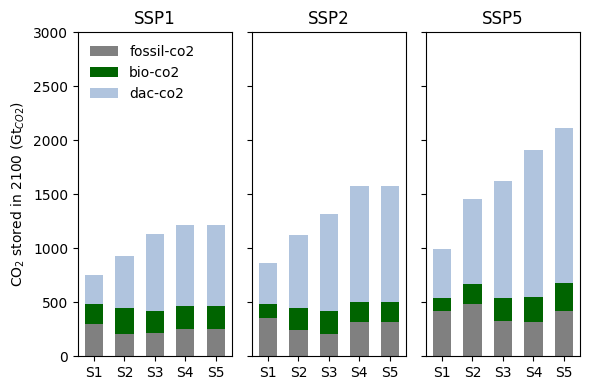

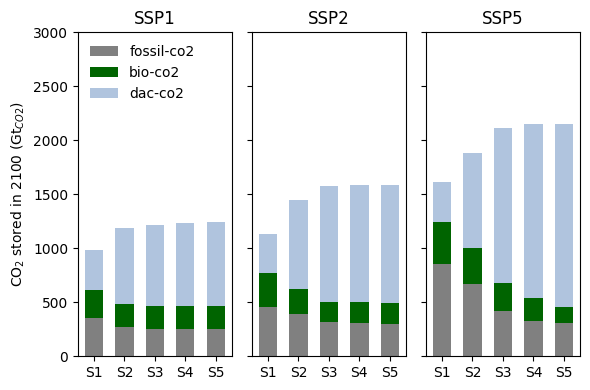

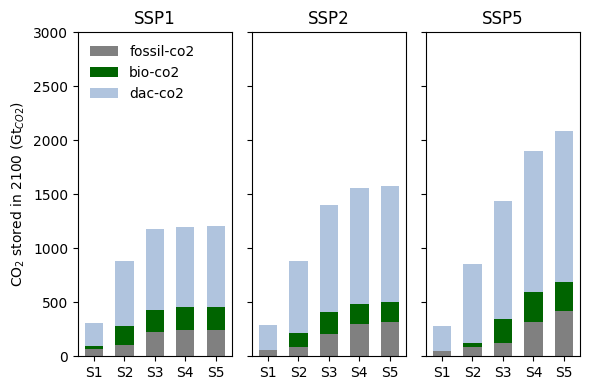

In [5]:
terms = ["long-term","short-term"]

for par in list(parameters):
    mp = ixmp.Platform()

    storage_list = []
    for ssp in ssps:
        for p in range(len(parameters[par].keys())):
            model = f"SSP_dev_{ssp}_v0.1_dac"
            if par == "mpens":
                scenario = f"1000f_v0.13_dac-co2split_{list(parameters[par].keys())[p]}"
            else:
                scenario = f"1000f_v0.13_dac-co2split_mpen3_{list(parameters[par].keys())[p]}"
            
            scen = message_ix.Scenario(mp, model=model, scenario=scenario)
            
            removal = (scen.var("ACT", {"technology":"co2_stor"})
                       .drop(["technology","year_vtg","time"], axis=1)
                       .set_index(["node_loc","year_act","mode"])["lvl"]
                      ).swaplevel(1,2).unstack().swaplevel(0,1).groupby(level=[0]).sum()
            removal.index = ["fossil-co2","bio-co2","dac-co2"]
            len_periods = [5,5,5,5,5,5,5,5,10,10,10,10,10]
            removal = removal.mul(len_periods, axis=1)

            cumulative_storage = removal.cumsum(axis=1).div(1000).mul(3.67) # make it GtCO2

            total_stor = cumulative_storage[[2100]]
            total_stor = total_stor.rename(columns={2100:f"{ssp}\n{list(parameters[par].keys())[p]}"})

            storage_list += [total_stor]

    mpen_names = ["S1","S2","S3","S4","S5"]

    ssp1_total_stor = pd.concat(storage_list[0:5], axis=1).transpose()
    ssp1_total_stor.index = mpen_names
    ssp1_total_stor = ssp1_total_stor.transpose()
    ssp2_total_stor = pd.concat(storage_list[5:10], axis=1).transpose()
    ssp2_total_stor.index = mpen_names
    ssp2_total_stor = ssp2_total_stor.transpose()
    ssp5_total_stor = pd.concat(storage_list[10:15], axis=1).transpose()
    ssp5_total_stor.index = mpen_names
    ssp5_total_stor = ssp5_total_stor.transpose()

    ssp_total_stor = [ssp1_total_stor,ssp2_total_stor,ssp5_total_stor]

    colors = {"fossil-co2":"gray","bio-co2":"darkgreen","dac-co2":"lightsteelblue"}

    width = 0.6

    fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(6,4))
    bottom1 = np.zeros(5)
    bottom2 = np.zeros(5)
    bottom5 = np.zeros(5)

    for source in colors.keys():
        ssp1 = axs[0].bar(ssp1_total_stor.columns, ssp1_total_stor.loc[source], width, label=source, bottom=bottom1,
                   color = colors[source]
                  )
        ssp2 = axs[1].bar(ssp2_total_stor.columns, ssp2_total_stor.loc[source], width, label=source, bottom=bottom2,
                   color = colors[source]
                  )
        ssp5 = axs[2].bar(ssp5_total_stor.columns, ssp5_total_stor.loc[source], width, label=source, bottom=bottom5,
                   color = colors[source]
                  )

        bottom1 += ssp1_total_stor.loc[source]
        bottom2 += ssp2_total_stor.loc[source]
        bottom5 += ssp5_total_stor.loc[source]

    #ax.set_xticks(range(2025,2045,5))
    axs[0].set_title("SSP1")
    axs[1].set_title("SSP2")
    axs[2].set_title("SSP5")
    axs[0].set_ylim(0,3000)
    axs[0].set_ylabel("CO$_2$ stored in 2100 (Gt$_{CO2}$)")
    axs[0].legend(loc="upper left", frameon=False)
    plt.tight_layout()
    plt.savefig(f"{par}_cum-co2stored.jpeg",dpi=300)
    plt.show()
        
    mp.close_db()

In [6]:
bottom5

S1     278.039511
S2     852.753396
S3    1435.253050
S4    1903.142560
S5    2087.596299
Name: fossil-co2, dtype: float64

In [7]:
mp.close_db()